## Module setup

# Changes: 
1) Training set: BSDS200, T91, General100

2) training patch 31x31 and stride is 21.

In [1]:
import os
import tarfile
import glob
import io
import random
from tqdm import tqdm
import shutil
import tarfile
import PIL
from IPython.display import display, Image
import numpy as np
from six.moves.urllib.request import urlretrieve
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.nn import Parameter
import torch.nn.functional as F
import torch.optim as optim
import time
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision import transforms

## Helper 
# RGB -> YCbCr and YCbCr -> RGB image conversion
This part is taken from Kornia
https://kornia.readthedocs.io/en/latest/_modules/kornia/color/ycbcr.html

In [2]:
def rgb_to_ycbcr(image: torch.Tensor) -> torch.Tensor:
    """Convert an RGB image to YCbCr.

    Args:
        image (torch.Tensor): RGB Image to be converted to YCbCr with shape :math:`(*, 3, H, W)`.

    Returns:
        torch.Tensor: YCbCr version of the image with shape :math:`(*, 3, H, W)`.

    Examples:
        >>> input = torch.rand(2, 3, 4, 5)
        >>> output = rgb_to_ycbcr(input)  # 2x3x4x5
    """
    if not isinstance(image, torch.Tensor):
        raise TypeError("Input type is not a torch.Tensor. Got {}".format(
            type(image)))

    if len(image.shape) < 3 or image.shape[-3] != 3:
        raise ValueError("Input size must have a shape of (*, 3, H, W). Got {}"
                         .format(image.shape))

    r: torch.Tensor = image[..., 0, :, :]
    g: torch.Tensor = image[..., 1, :, :]
    b: torch.Tensor = image[..., 2, :, :]

    delta: float = 0.5
    y: torch.Tensor = 0.299 * r + 0.587 * g + 0.114 * b
    cb: torch.Tensor = (b - y) * 0.564 + delta
    cr: torch.Tensor = (r - y) * 0.713 + delta
    return torch.stack([y, cb, cr], -3)



def ycbcr_to_rgb(image: torch.Tensor) -> torch.Tensor:
    """Convert an YCbCr image to RGB.

    The image data is assumed to be in the range of (0, 1).

    Args:
        image (torch.Tensor): YCbCr Image to be converted to RGB with shape :math:`(*, 3, H, W)`.

    Returns:
        torch.Tensor: RGB version of the image with shape :math:`(*, 3, H, W)`.

    Examples:
        >>> input = torch.rand(2, 3, 4, 5)
        >>> output = ycbcr_to_rgb(input)  # 2x3x4x5
    """
    if not isinstance(image, torch.Tensor):
        raise TypeError("Input type is not a torch.Tensor. Got {}".format(
            type(image)))

    if len(image.shape) < 3 or image.shape[-3] != 3:
        raise ValueError("Input size must have a shape of (*, 3, H, W). Got {}"
                         .format(image.shape))

    y: torch.Tensor = image[..., 0, :, :]
    cb: torch.Tensor = image[..., 1, :, :]
    cr: torch.Tensor = image[..., 2, :, :]

    delta: float = 0.5
    cb_shifted: torch.Tensor = cb - delta
    cr_shifted: torch.Tensor = cr - delta

    r: torch.Tensor = y + 1.403 * cr_shifted
    g: torch.Tensor = y - 0.714 * cr_shifted - 0.344 * cb_shifted
    b: torch.Tensor = y + 1.773 * cb_shifted
    return torch.stack([r, g, b], -3)



class RgbToYcbcr(nn.Module):
    """Convert an image from RGB to YCbCr.

    The image data is assumed to be in the range of (0, 1).

    Returns:
        torch.Tensor: YCbCr version of the image.

    Shape:
        - image: :math:`(*, 3, H, W)`
        - output: :math:`(*, 3, H, W)`

    Examples:
        >>> input = torch.rand(2, 3, 4, 5)
        >>> ycbcr = RgbToYcbcr()
        >>> output = ycbcr(input)  # 2x3x4x5
    """

    def __init__(self) -> None:
        super(RgbToYcbcr, self).__init__()

    def forward(self, image: torch.Tensor) -> torch.Tensor:
        return rgb_to_ycbcr(image)



class YcbcrToRgb(nn.Module):
    """Convert an image from YCbCr to Rgb.

    The image data is assumed to be in the range of (0, 1).

    Returns:
        torch.Tensor: RGB version of the image.

    Shape:
        - image: :math:`(*, 3, H, W)`
        - output: :math:`(*, 3, H, W)`

    Examples:
        >>> input = torch.rand(2, 3, 4, 5)
        >>> rgb = YcbcrToRgb()
        >>> output = rgb(input)  # 2x3x4x5
    """

    def __init__(self) -> None:
        super(YcbcrToRgb, self).__init__()

    def forward(self, image: torch.Tensor) -> torch.Tensor:
        return ycbcr_to_rgb(image)

## Directory setup and preparing the datasets

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
directory = '/content/memnet'
if not os.path.exists(directory):
  os.makedirs(directory)

os.chdir(directory)

## Model : Single-Supervised MemNet 

In [5]:
class FeatExtBlock(nn.Module):
    def __init__(self, in_channels=1, out_channels=64, kernel_size=3, stride=1, padding=1):
        super(FeatExtBlock, self).__init__()
        self.feature = nn.Sequential(nn.BatchNorm2d(1), nn.ReLU(),
                                     nn.Conv2d(in_channels=in_channels, out_channels=out_channels, 
                                               kernel_size=kernel_size, stride=stride,
                                               padding=padding, bias=False))

    def forward(self, x):
        fe_out = self.feature(x)
        return fe_out

In [6]:
class ResidualBlock(nn.Module):
  def __init__(self, n_layers=2, n_channels=64, kernel_size=3, stride=1, padding=1):
    super(ResidualBlock, self).__init__()
    layers = []
    for _ in range(n_layers):
      layers.append(nn.BatchNorm2d(n_channels))
      layers.append(nn.ReLU())
      layers.append(nn.Conv2d(in_channels=n_channels, out_channels=n_channels, kernel_size=kernel_size,
                              stride=stride, padding=padding, bias=False))
    
    self.residual = nn.Sequential(*layers)

  def forward(self, x):
    out = self.residual(x)
    return out + x

In [7]:
class RecursiveUnit(nn.Module):
  def __init__(self, n_short=6, d_conv=64):
    super(RecursiveUnit, self).__init__()
    self.n_short = n_short
    self.residual = nn.ModuleList([ResidualBlock(n_layers=2, n_channels=d_conv) for _ in range(n_short)])

  def forward(self, b_prev_m):
    Hs = []
    Hs.append(self.residual[0](b_prev_m))
    for rec in range(1, self.n_short):
      Hs.append(self.residual[rec](Hs[-1]))
    b_short = torch.cat(Hs, dim=1)
    return b_short

In [8]:
class GateUnit(nn.Module):
    def __init__(self, in_channels, d_conv=64):
        super(GateUnit, self).__init__()
        self.in_channels = in_channels
        self.gate_layer = nn.Sequential(nn.BatchNorm2d(in_channels), nn.ReLU(),
                                  nn.Conv2d(in_channels=self.in_channels, out_channels=d_conv, kernel_size=1,
                                            stride=1, padding=0, bias=False))

    def forward(self, b_gate):
        b_mem = self.gate_layer(b_gate)
        return b_mem

In [9]:
class MemBlock(nn.Module):
  def __init__(self, n_long, N_short=6, d_conv=64):
    super(MemBlock, self).__init__()
    self.n_long = n_long
    self.N_long = N_short
    self.d_conv = d_conv
    self.gate_in = (n_long + N_short) * d_conv
    self.short_unit = RecursiveUnit(N_short, d_conv)
    self.gate = GateUnit(self.gate_in, self.d_conv)

  def forward(self, b_long):
    b_short = self.short_unit(b_long[:, -self.d_conv:, :, :])
    b_gate = torch.cat([b_short, b_long], dim=1)
    b_m = self.gate(b_gate)
    return b_m

In [10]:
class ReconstBlock(nn.Module):
  def __init__(self, d_conv=64, kernel_size=3, stride=1, padding=1):
    super(ReconstBlock, self).__init__()
    self.d_conv = d_conv
    self.recon = nn.Sequential(nn.BatchNorm2d(d_conv), nn.ReLU(),
                               nn.Conv2d(in_channels=d_conv, out_channels=1, kernel_size=kernel_size,
                                         stride=stride, padding=padding, bias=False))

  def forward(self, b_m, x):
    y = self.recon(b_m)
    return y+x

In [11]:
class MemNet_SS(nn.Module):
    def __init__(self, N_long, N_short, d_conv=64):
        super(MemNet_SS, self).__init__()
        self.N_long = N_long
        self.N_short = N_short
        self.d_conv = d_conv
        self.fe_block = FeatExtBlock(1, d_conv)
        self.mem_blocks = nn.ModuleList([MemBlock(n_mem+1, N_short, d_conv) for n_mem in range(N_long)])
        self.recon_block = ReconstBlock(d_conv)
        # This part is taken from: https://discuss.pytorch.org/t/contraining-weights-to-sum-to-1/20609/2
        # self.eps = 1E-7
        # self.linavg = nn.Parameter((1./self.N_long) * torch.ones(N_long), requires_grad=True)

    def forward(self, x):
      fe = self.fe_block(x)
      b_ms = []
      b_ms.append(fe)
      y = torch.zeros_like(x)
      for n_mem in range(self.N_long):
        b_long = torch.cat(b_ms, dim=1)
        b_ms.append(self.mem_blocks[n_mem](b_long))
        # self.linavg = self.linavg.clamp(min=self.eps) # in case weights > 0
        # linavg_sum = self.linavg.sum(0, keepdim=True)
        # y += self.linavg[n_mem] * self.recon_block(b_ms[-1], x) / linavg_sum
      
      y = self.recon_block(b_ms[-1], x)
      return y

In [12]:
def size_check():
  p = torch.rand(2, 1, 4, 4)
  print(p.size())
  d_conv = 8
  fe_model = FeatExtBlock(1, d_conv)
  q = fe_model(p)
  print(q.size())
  mem_model = MemBlock(1, 6, d_conv)
  r = mem_model(q)
  print(r.size())
  recon_model = ReconstBlock(d_conv)
  s = recon_model(r, p)
  print(s.size())
  model = MemNet_SS(2, 2, 32)
  t = model(p)
  print(t.size())

size_check()

torch.Size([2, 1, 4, 4])
torch.Size([2, 8, 4, 4])
torch.Size([2, 8, 4, 4])
torch.Size([2, 1, 4, 4])
torch.Size([2, 1, 4, 4])


## Dataset Preparation

In [13]:
class DatasetSR(Dataset):
  def __init__(self, images_dir, transform=None):
    self.files = []
    for dir in images_dir:
      self.files += glob.glob(dir + '/*')
    self.files = sorted(self.files)
    self.transform=transform
  
  def __len__(self):
    return len(self.files)

  def __getitem__(self, index):
    image_path = self.files[index]
    hr_image = PIL.Image.open(image_path)
    hr_image = hr_image.convert('YCbCr')
    # random_gen = int(image_path.split('/')[-1].split('_')[-2][-1]) + int(image_path.split('/')[-1].split('_')[-1][-5])
    # scale = random_gen % 3 + 2 
    scale = random.randint(2, 4)
    width_down = hr_image.width // scale
    heigth_down = hr_image.height // scale
    lr_image = hr_image.resize((width_down, heigth_down),
                               resample=PIL.Image.BICUBIC)
    lr_image = lr_image.resize((hr_image.width, hr_image.height),
                               resample=PIL.Image.BICUBIC)
    
    trans_toten = transforms.ToTensor()
    hr_ten = trans_toten(hr_image)
    lr_ten = trans_toten(lr_image)
    hr_ten = rgb_to_ycbcr(hr_ten)
    lr_ten = rgb_to_ycbcr(lr_ten)
    
    if self.transform:
            hr = self.transform(hr_image)
            lr = self.transform(lr_image)

    return hr, lr

## Training

In [14]:
class AttrDict(dict):
  def __init__(self, *args, **kwargs):
    super(AttrDict, self).__init__(*args, **kwargs)
    self.__dict__ = self

def weights_init(m):
  if isinstance(m, nn.Conv2d):
    nn.init.xavier_normal_(m.weight.data, gain=1.0)
    # nn.init.zeros_(m.bias.data)

# The following function si taken from: https://medium.com/analytics-vidhya/saving-and-loading-your-model-to-resume-training-in-pytorch-cb687352fa61
def load_ckp(checkpoint_fpath, model):
    checkpoint = torch.load(checkpoint_fpath)
    model.load_state_dict(checkpoint)
    # optimizer.load_state_dict(checkpoint['optimizer'])
    return model

def train(args):
  model = MemNet_SS(args.N_long, args.N_short, args.d_conv)
  model.train()
  if torch.cuda.is_available():
    print("sending model to cuda...")
    model = model.cuda()
  # optimizer = optim.Adam(model.parameters(), lr=args.lr)
  optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum, weight_decay=args.w_decay)
  if args['start_from']:
    print('starting from {}'.format(args.start_from))
    checkpoint = torch.load(args.start_from)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    # model = load_ckp(args['start_from'], model)
  else:
    print("initializing the model...")
    model.apply(weights_init)
  
  scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=args.epochs//8, gamma=args.gamma)
  criterion = nn.MSELoss(reduction='sum')
  trnsfrm = transforms.Compose([transforms.ToTensor()])
  # dataset = Dataset(opt.images_dir, opt.patch_size, opt.jpeg_quality, opt.use_fast_loader)
  dataset = DatasetSR(images_dir=args.train_dir, transform=trnsfrm)
  dataloader = DataLoader(dataset=dataset,
                          batch_size=args.batch_size,
                          shuffle=True,
                          num_workers=args.threads,
                          pin_memory=True,
                          drop_last=False)
  
  print('Training starts...')
  start = time.time()
  train_losses = []
  valid_losses = []
  for epoch in range(args.epochs):
    losses = []
    for i, data in enumerate(dataloader):
      y, x = data
      x = x[:, 0, :, :].unsqueeze(1)
      y = y[:, 0, :, :].unsqueeze(1)
      if torch.cuda.is_available():
        x = x.cuda()
        y = y.cuda()
      
      x_hat = model(x)
      # print("evaluated")
      loss = (0.5/args.batch_size)*criterion(x_hat, y)
      optimizer.zero_grad()
      loss.backward()
      nn.utils.clip_grad_norm_(model.parameters(), args.clip) 
      optimizer.step()
      losses.append(loss.data.item())

    # print("moving forward...")
    scheduler.step()
    avg_loss = np.mean(losses)
    train_losses.append(avg_loss)
    time_elapsed = time.time() - start
    print('Epoch [%d/%d], Loss: %.4f, Time (s): %d'
          % (epoch + 1, args.epochs, avg_loss, time_elapsed)
        )
    if (epoch+1) % 5 == 0:
      patch_checkpoint = os.path.join(args.output_dir, 'memnet_epoch_{}.pt'.format(epoch+1))
      torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            }, patch_checkpoint)
      # torch.save(model.state_dict(), os.path.join(args.output_dir, 'memnet_epoch_{}.pt'.format(epoch+1)))

  # Plot training curve
  plt.figure()
  plt.plot(train_losses, "ro-", label="Train")
  # plt.plot(valid_losses, "go-", label="Validation")
  plt.legend()
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.show()
  plt.savefig(os.path.join(args.output_dir, "train_loss.png"))
  
  return model

In [15]:
drive_dir = '/content/drive/MyDrive/memnet/memnet_ss_4s4m'
if not os.path.exists(drive_dir):
  os.makedirs(drive_dir)

patch_size = 31
trainings = ['BSDS200_p'+str(patch_size), 'T91_p'+str(patch_size), 'General100_p'+str(patch_size)]
args = AttrDict()
args_dict = {
    'threads' : 1,
    'kernel_size' : 3,
    'N_long' : 4,
    'N_short' : 4,
    'd_conv' : 64,
    'lr' : 0.1,
    'momentum' : 0.9,
    'w_decay' : 1E-4,
    'clip' : 0.4,
    'gamma' : 0.2,
    'batch_size':128,
    'patch_size': patch_size,
    'epochs' : 80,
    'train_dir' : [directory+'/'+trainings[i] for i in range(len(trainings))],
    'output_dir' : drive_dir,
    'start_from' : ''
}
args.update(args_dict)

In [16]:
gdrive_tdir = '/content/drive/MyDrive/memnet'
for tri in trainings:
  shutil.copy(os.path.join(gdrive_tdir, tri + '.tar.gz'), directory)
  file = tarfile.open(os.path.join(directory, tri + '.tar.gz'))
  file.extractall('./')
  file.close()
  print(len(next(os.walk('./'+tri))[2]))

# !ls /content/drive/MyDrive/memnet
# !cp /content/drive/MyDrive/memnet/T91_p51.tar.gz /content/memnet/T91_p51.tar.gz
# with tarfile.open('T91_p51.tar.gz') as archive:
#   archive.extractall(directory)

# !cp /content/drive/MyDrive/memnet/BSDS200_p51.tar.gz /content/memnet/BSDS200_p51.tar.gz
# with tarfile.open('BSDS200_p51.tar.gz') as archive:
#   archive.extractall(directory)

# !cp /content/drive/MyDrive/memnet/General100_p51.tar.gz /content/memnet/General100_p51.tar.gz
# with tarfile.open('General100_p51.tar.gz') as archive:
#   archive.extractall(directory)

# !ls /content/memnet/T91_p51/ -1 | wc -l
# !ls /content/memnet/BSDS200_p51/ -1 | wc -l
# !ls /content/memnet/General100_p31/ -1 | wc -l

73600
13115
42803


sending model to cuda...
initializing the model...
Training starts...
Epoch [1/80], Loss: 4.9763, Time (s): 233
Epoch [2/80], Loss: 1.1671, Time (s): 467
Epoch [3/80], Loss: 1.1293, Time (s): 701
Epoch [4/80], Loss: 1.1108, Time (s): 935
Epoch [5/80], Loss: 1.1039, Time (s): 1169
Epoch [6/80], Loss: 1.0971, Time (s): 1404
Epoch [7/80], Loss: 1.0900, Time (s): 1638
Epoch [8/80], Loss: 1.0871, Time (s): 1871
Epoch [9/80], Loss: 1.0807, Time (s): 2105
Epoch [10/80], Loss: 1.0849, Time (s): 2339
Epoch [11/80], Loss: 1.0454, Time (s): 2574
Epoch [12/80], Loss: 1.0420, Time (s): 2807
Epoch [13/80], Loss: 1.0401, Time (s): 3041
Epoch [14/80], Loss: 1.0361, Time (s): 3275
Epoch [15/80], Loss: 1.0342, Time (s): 3509
Epoch [16/80], Loss: 1.0316, Time (s): 3744
Epoch [17/80], Loss: 1.0349, Time (s): 3977
Epoch [18/80], Loss: 1.0334, Time (s): 4211
Epoch [19/80], Loss: 1.0254, Time (s): 4445
Epoch [20/80], Loss: 1.0264, Time (s): 4679
Epoch [21/80], Loss: 1.0207, Time (s): 4914
Epoch [22/80], Loss

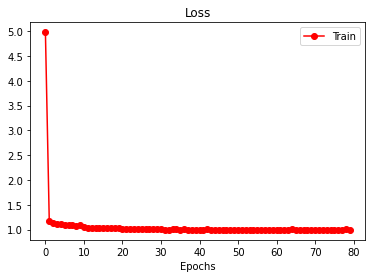

KeyboardInterrupt: ignored

<Figure size 432x288 with 0 Axes>

In [17]:
memnet = train(args)
while True:pass

In [18]:
drive_dir = '/content/drive/MyDrive/memnet/memnet_ss_4s4m'
if not os.path.exists(drive_dir):
  os.makedirs(drive_dir)

patch_size = 31
trainings = ['BSDS200_p'+str(patch_size), 'T91_p'+str(patch_size), 'General100_p'+str(patch_size)]
args = AttrDict()
args_dict = {
    'threads' : 1,
    'kernel_size' : 3,
    'N_long' : 4,
    'N_short' : 4,
    'd_conv' : 64,
    'lr' : 0.1,
    'momentum' : 0.9,
    'w_decay' : 1E-4,
    'clip' : 0.4,
    'gamma' : 0.2,
    'batch_size':128,
    'patch_size': patch_size,
    'epochs' : 80,
    'train_dir' : [directory+'/'+trainings[i] for i in range(len(trainings))],
    'output_dir' : drive_dir,
    'start_from' : ''
}
args.update(args_dict)

patch_checkpoint = os.path.join(args.output_dir, 'memnet_epoch_{}.pt'.format(80))
torch.save({
      'epoch': 80,
      'model_state_dict': memnet.state_dict(),
      'optimizer_state_dict': None,
      'loss': None,
      }, patch_checkpoint)